In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [11]:
df = load_pkl('data/feat_engin/lgbm/data_1hour_1day.pkl')
df["income_rate"] = np.maximum(df["income_rate"], 0.97)
df["income_rate"] = np.minimum(df["income_rate"], 1.05)

In [12]:
df.shape

(971600, 682)

In [14]:
df.head()

,time,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,volume_w1_roc,...,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w100_min/close_1day_w100_max,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max
0,2022-05-04 18:00:00,AFLT,0.0,LOSE,1 days 20:00:00,0.97,30.260000,22,-0.000641,-0.110107,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2022-05-05 10:00:00,AFLT,0.0,LOSE,1 days 02:00:00,0.97,30.280001,20,0.001282,1.836605,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-05-05 11:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.97,30.020000,28,-0.008323,-0.239264,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,2022-05-05 12:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.97,29.920000,29,-0.001937,-0.628420,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2022-05-05 13:00:00,AFLT,0.0,LOSE,5 days 23:00:00,0.97,29.920000,29,0.000000,-0.145421,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
df['result'].value_counts(normalize=True)

result
LOSE    0.400563
DNF     0.342511
WIN     0.256926
Name: proportion, dtype: float64

In [21]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.970000
0.01    0.970000
0.10    0.970000
0.20    0.970000
0.30    0.970000
0.40    0.970000
0.50    0.995276
0.60    1.009394
0.70    1.028605
0.80    1.050000
0.90    1.050000
0.99    1.050000
1.00    1.050000
Name: income_rate, dtype: float64

In [24]:
# Используем уже знакомую функцию :)

def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: 
        mask_val_first = np.array(df['close'] > val_first)      ### тут будущему мне поразбираться нужно будет
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        income_rate = res_price/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        income_rate = res_price/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        income_rate = res_price/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            income_rate = res_price/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            income_rate = res_price/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result    

In [27]:
df_result = load_pkl('./data/feat_engin/df_result_wait_35_7days.pkl')
df_result = df_result[['time', 'close', 'ticker']]
df_result

,time,close,ticker
0,2022-05-04 10:00:00,32.100,AFLT
1,2022-05-04 11:00:00,31.380,AFLT
2,2022-05-04 12:00:00,31.800,AFLT
3,2022-05-04 13:00:00,31.360,AFLT
4,2022-05-04 14:00:00,31.540,AFLT
...,...,...,...
972606,2024-12-31 19:00:00,10.830,RBCM
972607,2024-12-31 20:00:00,10.775,RBCM
972608,2024-12-31 21:00:00,10.820,RBCM
972609,2024-12-31 22:00:00,10.765,RBCM


In [30]:
inds = np.arange(df_result.shape[0])
inds.shape

(972611,)

In [32]:
df_result = get_df_target(df_result, inds, percent_first=0.98, percent_second=1.04, points_to_wait=14*2)

100%|███████████████████████████████████████████████████████████████| 972611/972611 [03:47<00:00, 4267.25it/s]


In [33]:
df_result["income_rate"] = np.maximum(df_result["income_rate"], 0.98)
df_result["income_rate"] = np.minimum(df_result["income_rate"], 1.04)

In [34]:
df_result['result'].value_counts(normalize=True)

result
DNF     0.469662
LOSE    0.362799
WIN     0.167540
Name: proportion, dtype: float64

In [35]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.987879
0.50    0.996732
0.60    1.003657
0.70    1.012181
0.80    1.026575
0.90    1.040000
0.99    1.040000
1.00    1.040000
Name: income_rate, dtype: float64

In [39]:
(df_result['ind'] == df_result.index).all(), 

(True,)

In [40]:
df_result.columns

Index(['ind', 'time', 'close', 'result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind'],
      dtype='object')

In [41]:
df_result = df_result[['time','result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind']]
df_result

,time,result,ticker,delta_time,income_rate,res_price,res_ind
0,2022-05-04 10:00:00,LOSE,AFLT,0 days 01:00:00,0.980000,31.38,1
1,2022-05-04 11:00:00,LOSE,AFLT,1 days 05:00:00,0.980000,30.64,15
2,2022-05-04 12:00:00,LOSE,AFLT,0 days 04:00:00,0.980000,31.16,6
3,2022-05-04 13:00:00,LOSE,AFLT,1 days 03:00:00,0.980000,30.64,15
4,2022-05-04 14:00:00,LOSE,AFLT,1 days 02:00:00,0.980000,30.64,15
...,...,...,...,...,...,...,...
972606,2024-12-31 19:00:00,DNF,RBCM,0 days 04:00:00,0.994460,10.77,972610
972607,2024-12-31 20:00:00,DNF,RBCM,0 days 03:00:00,0.999536,10.77,972610
972608,2024-12-31 21:00:00,DNF,RBCM,0 days 02:00:00,0.995379,10.77,972610
972609,2024-12-31 22:00:00,DNF,RBCM,0 days 01:00:00,1.000464,10.77,972610


In [42]:
df

,time,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,volume_w1_roc,...,tmos_close_1day_w3_min/tmos_close_1day_w3_max,close_1day_w5_min/close_1day_w5_max,volume_1day_w5_min/volume_1day_w5_max,tmos_close_1day_w5_min/tmos_close_1day_w5_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w100_min/close_1day_w100_max,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max
0,2022-05-04 18:00:00,AFLT,0.0,LOSE,1 days 20:00:00,0.970000,30.260000,22,-0.000641,-0.110107,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2022-05-05 10:00:00,AFLT,0.0,LOSE,1 days 02:00:00,0.970000,30.280001,20,0.001282,1.836605,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2022-05-05 11:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.970000,30.020000,28,-0.008323,-0.239264,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,2022-05-05 12:00:00,AFLT,0.0,LOSE,6 days 00:00:00,0.970000,29.920000,29,-0.001937,-0.628420,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,2022-05-05 13:00:00,AFLT,0.0,LOSE,5 days 23:00:00,0.970000,29.920000,29,0.000000,-0.145421,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971595,2024-12-31 19:00:00,RBCM,85511.0,DNF,0 days 04:00:00,0.994460,10.770000,972610,0.002778,-0.907692,...,0.952153,0.930826,0.452483,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536
971596,2024-12-31 20:00:00,RBCM,85511.0,DNF,0 days 03:00:00,0.999536,10.770000,972610,-0.005078,-0.833333,...,0.952153,0.930826,0.452483,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536
971597,2024-12-31 21:00:00,RBCM,85511.0,DNF,0 days 02:00:00,0.995379,10.770000,972610,0.004176,9.000000,...,0.952153,0.930826,0.452483,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536
971598,2024-12-31 22:00:00,RBCM,85511.0,DNF,0 days 01:00:00,1.000464,10.770000,972610,-0.005083,4.900000,...,0.952153,0.930826,0.452483,0.934609,0.845404,0.104588,0.832536,0.523727,0.012193,0.832536


In [44]:
df.shape

(971600, 682)

In [45]:
#join
df = df[df.columns[~df.columns.isin(['result', 'delta_time', 'income_rate', 'res_price', 'res_ind'])]].merge(
    df_result, how='inner', on=['time', 'ticker'])
df.shape

(971600, 682)

In [62]:
df.head()

,time,ticker,index_1day,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,...,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w100_min/close_1day_w100_max,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max,result,delta_time,income_rate,res_price,res_ind,target
0,2022-05-04 18:00:00,AFLT,0.0,-0.000641,-0.110107,-0.007126,0.004979,0.004078,-8.443163,37.500000,...,1.0,1.0,1.0,1.0,LOSE,1 days 16:00:00,0.98,30.38,18,0
1,2022-05-05 10:00:00,AFLT,0.0,0.001282,1.836605,0.009569,0.002413,0.003187,-8.802817,20.000000,...,1.0,1.0,1.0,1.0,LOSE,1 days 00:00:00,0.98,30.38,18,0
2,2022-05-05 11:00:00,AFLT,0.0,-0.008323,-0.239264,-0.002370,0.003366,0.003710,-7.727273,17.241379,...,1.0,1.0,1.0,1.0,LOSE,1 days 01:00:00,0.98,30.28,20,0
3,2022-05-05 12:00:00,AFLT,0.0,-0.001937,-0.628420,0.002375,0.004823,0.002822,-9.103020,22.727272,...,1.0,1.0,1.0,1.0,LOSE,1 days 00:00:00,0.98,30.28,20,0
4,2022-05-05 13:00:00,AFLT,0.0,0.000000,-0.145421,0.002370,0.005022,0.002436,-9.046053,10.526316,...,1.0,1.0,1.0,1.0,LOSE,0 days 23:00:00,0.98,30.28,20,0


### 1. train/valid/test/test2 split

In [66]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

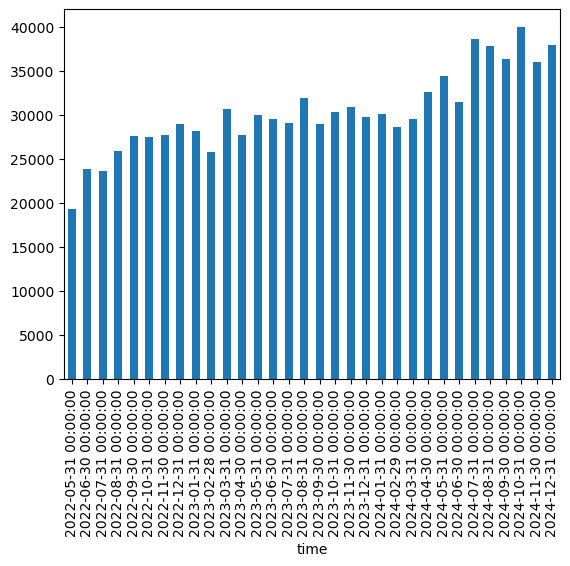

In [68]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

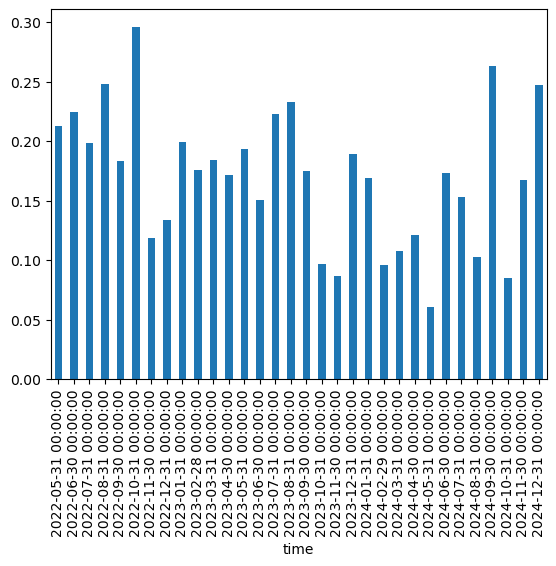

In [69]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

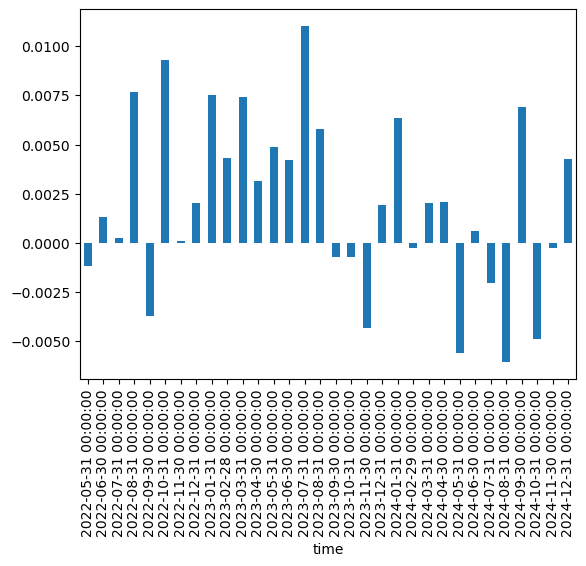

In [72]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [75]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-12-23')))
#mask_test2 = mask_test

In [77]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(744713, 76495, 76398, 61912)

In [80]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 102
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all


#мб дату неправильно обрезаю

In [81]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(627417, 76495, 76398, 61912)

In [82]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

842222

In [83]:
df.loc[mask_data].isnull().sum()[df.loc[mask_data].isnull().sum() > 0].sort_values()

Series([], dtype: int64)

In [86]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7449544181937778,
 0.09082522185362055,
 0.0907100503192745,
 0.07351030963332708)

In [87]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.15942985287296965,
 0.12809987580887638,
 0.1698342888557292,
 0.19904057371753456)

In [88]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0027913515198363, 0.995977311733386, 1.0007246795405644, 1.0005853477255073)

In [97]:
#проверки

In [99]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

In [103]:
df.head()

,time,ticker,index_1day,close_w1_roc,volume_w1_roc,tmos_close_w1_roc,close_w5_norm_std,close_w5_mean_abs_pct,close_w5_alpha,close_w5_rsi,...,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w100_min/close_1day_w100_max,volume_1day_w100_min/volume_1day_w100_max,tmos_close_1day_w100_min/tmos_close_1day_w100_max,result,delta_time,income_rate,res_price,res_ind,target
0,2022-05-04 18:00:00,AFLT,0.0,-0.000641,-0.110107,-0.007126,0.004979,0.004078,-8.443163,37.500000,...,1.0,1.0,1.0,1.0,LOSE,1 days 16:00:00,0.98,30.38,18,0
1,2022-05-05 10:00:00,AFLT,0.0,0.001282,1.836605,0.009569,0.002413,0.003187,-8.802817,20.000000,...,1.0,1.0,1.0,1.0,LOSE,1 days 00:00:00,0.98,30.38,18,0
2,2022-05-05 11:00:00,AFLT,0.0,-0.008323,-0.239264,-0.002370,0.003366,0.003710,-7.727273,17.241379,...,1.0,1.0,1.0,1.0,LOSE,1 days 01:00:00,0.98,30.28,20,0
3,2022-05-05 12:00:00,AFLT,0.0,-0.001937,-0.628420,0.002375,0.004823,0.002822,-9.103020,22.727272,...,1.0,1.0,1.0,1.0,LOSE,1 days 00:00:00,0.98,30.28,20,0
4,2022-05-05 13:00:00,AFLT,0.0,0.000000,-0.145421,0.002370,0.005022,0.002436,-9.046053,10.526316,...,1.0,1.0,1.0,1.0,LOSE,0 days 23:00:00,0.98,30.28,20,0


In [108]:
df_5min.reset_index(inplace=True)
df_1hour.reset_index(inplace=True)
df_1day.reset_index(inplace=True)

NameError: name 'df_5min' is not defined

In [75]:
df = df_1min.merge(df_5min, left_on='index_5min', right_on='index', how='left', suffixes=("_j1min", "_j5min"))
df = df.merge(df_1hour, left_on='index_1hour', right_on='index', how='left', suffixes=("_j5min", "_j1hour"))
df = df.merge(df_1day, left_on='index_1day', right_on='index', how='left', suffixes=("_j1hour", "_j1day"))

df.shape

(3816149, 188)

In [77]:
df.head()

,time_j1min,close,volume,ticker_j1min,index_1min_start,index_5min,index_start_5min,index_1hour,index_start_1hour,index_1day,...,close_1day_w200_min,close_1day_w200_max,close_1day_w200_rsi,volume_1day_w200_ma,volume_1day_w200_std,volume_1day_w200_min,volume_1day_w200_max,volume_1day_w200_rsi,sin_time_weekday,cos_time_weekday
0,2023-10-02 11:00:00,168.039993,860.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
1,2023-10-02 11:01:00,168.009995,1965.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
2,2023-10-02 11:02:00,167.990005,773.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
3,2023-10-02 11:03:00,167.949997,3115.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0
4,2023-10-02 11:04:00,167.940002,5051.0,GAZP,0.0,41933.0,0.0,3601.0,0.0,253.0,...,153.089996,184.389999,51.084591,2912151.75,2348000.0,524716.0,18061598.0,50.249245,-2.449294e-16,1.0


In [79]:
df.isnull().sum()

time_j1min              0
close                   0
volume                  0
ticker_j1min            0
index_1min_start        0
                       ..
volume_1day_w200_min    0
volume_1day_w200_max    0
volume_1day_w200_rsi    0
sin_time_weekday        0
cos_time_weekday        0
Length: 188, dtype: int64

In [32]:
df_1min.shape, df.shape

((3816149, 49), (3816149, 188))

In [33]:
df['ticker_j1min'].notnull().sum(), df['ticker_j5min'].notnull().sum(), df['ticker_j1hour'].notnull().sum(), df['ticker_j1day'].notnull().sum(), 

(3816149, 3816149, 3816149, 3816149)

##### ticker

In [35]:
df['ticker_code'] = df['ticker_j1min'].astype('category').cat.codes

In [36]:
dict(enumerate(df['ticker_j1min'].astype('category').cat.categories))

{0: 'ALRS',
 1: 'CHMF',
 2: 'GAZP',
 3: 'GMKN',
 4: 'LKOH',
 5: 'MAGN',
 6: 'MGNT',
 7: 'MTSS',
 8: 'NLMK',
 9: 'NVTK',
 10: 'OZON',
 11: 'ROSN',
 12: 'RUAL',
 13: 'SBER',
 14: 'SNGS',
 15: 'SNGSP',
 16: 'T',
 17: 'TATN',
 18: 'YDEX'}

### 3. Model

In [105]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [107]:
df['ticker_code'].nunique()

127

In [109]:
df.loc[mask_train, 'ticker_code'].nunique()

127

In [111]:
df.columns.tolist()

['time',
 'ticker',
 'index_1day',
 'close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_-0.99-1',
 'close_w70_lvl_1.01-1.02',
 'close_w70_lvl_-0.98-0.99',
 'close_w70_l

In [285]:
drop_cols = ['time',
             #'ticker_code',
             'hour', 'day', 'weekday', 
             'month',

 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind', 'index', 'target', 
              'ind', 'close',
             'y_pred'] #+ [elem for elem in df.columns if 'roc' in elem]


features = df.columns[~df.columns.isin(drop_cols)].tolist()

#features = [elem for elem in df.columns if (('/' in elem) or ('lvl' in elem) or ('alpha' in elem))] + ['ticker_code'] #+ ['hour', 'day', 'weekday']

cat_features = ['ticker_code',
                #'hour', 'day', 'weekday',# 'month'
]


target = 'target'

In [287]:
len(features)

670

In [289]:
features

['close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_-0.99-1',
 'close_w70_lvl_1.01-1.02',
 'close_w70_lvl_-0.98-0.99',
 'close_w70_lvl_1.02-1.03',
 'close_w70_lvl_-0.9

In [291]:
'ticker_code' in features

True

In [294]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], reference=D_train, feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


In [330]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 10_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.3,
     "bagging_fraction": 0.3,
     "bagging_freq": 1,
    # 'lambda_l1' : 1,
    # 'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 1000000,
    
    
    "metric": "auc",
    "early_stopping" : 20,

    
}

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 100029, number of negative: 527388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150300
[LightGBM] [Info] Number of data points in the train set: 627417, number of used features: 670
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159430 -> initscore=-1.662476
[LightGBM] [Info] Start training from score -1.662476
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's auc: 0.705189


In [332]:
model.num_trees()

68

In [334]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7260164602114832,
 0.7051885225404385,
 0.7040428827613305,
 0.5886534722707845)

In [335]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.469281
WIN     0.415686
DNF     0.115033
Name: proportion, dtype: float64
1.0080311301765759

Test
result
WIN     0.515831
LOSE    0.434037
DNF     0.050132
Name: proportion, dtype: float64
1.012531684631958

Test2
result
WIN     0.487805
LOSE    0.400000
DNF     0.112195
Name: proportion, dtype: float64
1.0131169281934782


In [336]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 21:30:00'),
 Timedelta('0 days 09:00:00'),
 Timedelta('0 days 15:00:00'))

In [337]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 16:00:00'),
 Timedelta('0 days 16:00:00'),
 Timedelta('0 days 18:00:00'))

In [344]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.99)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.39862012706983896

Valid
result
LOSE    0.469281
WIN     0.415686
DNF     0.115033
Name: proportion, dtype: float64
1.0080311301765759

Test
result
WIN     0.531889
LOSE    0.413959
DNF     0.054152
Name: proportion, dtype: float64
1.013670697161196

Tetst2
result
WIN     0.486239
LOSE    0.408257
DNF     0.105505
Name: proportion, dtype: float64
1.0128031439002527


In [347]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 19:00:00'),
 Timedelta('0 days 13:00:00'),
 Timedelta('0 days 15:00:00'))

In [349]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 17:00:00'),
 Timedelta('0 days 19:00:00'),
 Timedelta('0 days 19:00:00'))

In [353]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(765, 831, 872)

In [355]:
df.loc[mask_test2&mask, 'time'].dt.date.nunique()

12

In [357]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['KROT', 'MRKY', 'CHMK', 'YAKG', 'PMSBP', 'RKKE', 'MRKZ', 'CNTL',
       'PMSB', 'NSVZ', 'VRSB', 'UWGN', 'ABIO', 'GTRK', 'BLNG', 'LSNG',
       'TGKB', 'IRKT', 'MGTSP', 'HEAD', 'KLSB', 'MSTT', 'DVEC', 'UNAC',
       'TGKBP', 'KZOS', 'MRKS', 'PRFN', 'RBCM'], dtype=object)

In [359]:
df.loc[mask_test2&mask, 'ticker'].value_counts()

ticker
TGKB     107
RBCM      86
BLNG      73
TGKBP     69
VRSB      67
KROT      62
DVEC      51
NSVZ      49
KLSB      45
MRKZ      42
PRFN      38
MRKY      36
RKKE      20
MSTT      18
CNTL      17
GTRK      12
PMSBP     12
UWGN      12
PMSB      11
UNAC       7
YAKG       7
LSNG       7
MRKS       6
IRKT       5
HEAD       4
KZOS       4
ABIO       3
MGTSP      1
CHMK       1
Name: count, dtype: int64

In [363]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w70_mean_abs_pct', 20.08),
 ('ticker_code', 17.83),
 ('volume_1day_w100_mean_abs_pct', 7.57),
 ('tmos_close_w70_ma_low_2std/tmos_close', 6.76),
 ('close_w70_min/close_w70_max', 6.56),
 ('volume_1day_w100_norm_std', 6.27),
 ('close_1day_w20_mean_abs_pct', 5.51),
 ('close_1day_w20_norm_std', 3.58),
 ('close_1day_w100_lvl_1.02-1.03', 3.05),
 ('close_1day_w100_min/close_1day_w100_max', 2.99),
 ('tmos_close_w70_std/tmos_close', 2.65),
 ('tmos_close_1day_w100_alpha', 2.55),
 ('tmos_close_1day_w5_rsi/tmos_close_1day_w20_rsi', 2.24),
 ('tmos_close_1day_w100_lvl_-0.9299999999999999-0.95', 2.06),
 ('tmos_close_1day_w5_roc/tmos_close_1day_w100_roc', 1.46),
 ('tmos_close_w5_ma_low_2std/tmos_close', 0.95),
 ('tmos_close_1day/tmos_close_1day_w20_max', 0.79),
 ('tmos_close_1day/tmos_close_1day_w100_min', 0.7),
 ('close_1day_w100_lvl_1.03-1.04', 0.64),
 ('tmos_close_1day_w100_roc', 0.63),
 ('tmos_close_1day_w3_roc/tmos_close_1day_w100_roc', 0.6),
 ('tmos_close_1day_w20_roc', 0.59),
 ('tmos_cl

# Best

In [369]:
top = []
for elem in zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)):
    if elem[1] > 0: 
        top += [elem[0]]
top

['close_w70_mean_abs_pct',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_1.01-1.02',
 'tmos_close/tmos_close_w14_max',
 'tmos_close/tmos_close_w70_max',
 'tmos_close_w5_ma_low_2std/tmos_close',
 'tmos_close_w70_std/tmos_close',
 'tmos_close_w70_ma_low_2std/tmos_close',
 'close_w70_min/close_w70_max',
 'close_1day_w20_norm_std',
 'close_1day_w20_mean_abs_pct',
 'tmos_close_1day_w20_roc',
 'close_1day_w100_lvl_1.02-1.03',
 'close_1day_w100_lvl_1.03-1.04',
 'volume_1day_w100_norm_std',
 'volume_1day_w100_mean_abs_pct',
 'tmos_close_1day_w100_mean_abs_pct',
 'tmos_close_1day_w100_alpha',
 'tmos_close_1day_w100_roc',
 'tmos_close_1day_w100_lvl_1-1.01',
 'tmos_close_1day_w100_lvl_-0.9299999999999999-0.95',
 'tmos_close_1day_w3_roc/tmos_close_1day_w100_roc',
 'tmos_close_1day_w5_roc/tmos_close_1day_w100_roc',
 'tmos_close_1day_w5_rsi/tmos_close_1day_w20_rsi',
 'tmos_close_1day/tmos_close_1day_w100_min',
 'tmos_close_1day_w3_min/tmos_close_1day_w100_min',
 'tmos_close_1day/tmos_close_1day_w20_max',

In [371]:
top_cat = ['ticker_code']

In [373]:
D_train = lgbm.Dataset(df.loc[mask_train, top], label=df.loc[mask_train, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top], label=df.loc[mask_valid, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top], label=df.loc[mask_test, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top], label=df.loc[mask_test2, target], feature_name=top, categorical_feature=top_cat, free_raw_data=False)


In [375]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 10_000,

    
    "num_leaves": 2,
    #"learning_rate": 0.001,
     "feature_fraction": 0.7,
     "bagging_fraction": 0.2,
     "bagging_freq": 1,
     'lambda_l1' : 1,
     'lambda_l2' : 1,
    #"verbose": 0,

    #'max_bin' : 1000000,
    
    
    "metric": "auc",
    "early_stopping" : 20,

    
}

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid])

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 100029, number of negative: 527388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6215
[LightGBM] [Info] Number of data points in the train set: 627417, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.159430 -> initscore=-1.662476
[LightGBM] [Info] Start training from score -1.662476
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[123]	valid_0's auc: 0.710452


In [377]:
model.num_trees()

123

In [379]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.738651243804128, 0.7104517715644243, 0.7062365497318264, 0.6024409455265413)

In [383]:
#свой threshold

q = 0.99

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] > threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.454902
WIN     0.431373
DNF     0.113725
Name: proportion, dtype: float64
1.0094012349743484

Test
result
LOSE    0.473062
WIN     0.442838
DNF     0.084100
Name: proportion, dtype: float64
1.009873517161745

Test2
result
WIN     0.469055
LOSE    0.449511
DNF     0.081433
Name: proportion, dtype: float64
1.0109932385306206


In [385]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 18:00:00'),
 Timedelta('0 days 12:00:00'),
 Timedelta('0 days 11:00:00'))

In [387]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 19:00:00'),
 Timedelta('0 days 16:00:00'),
 Timedelta('0 days 09:00:00'))

In [389]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] > threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.5032913648767325

Valid
result
LOSE    0.454902
WIN     0.431373
DNF     0.113725
Name: proportion, dtype: float64
1.0094012349743484

Test
result
LOSE    0.450903
WIN     0.450903
DNF     0.098193
Name: proportion, dtype: float64
1.0106198934978785

Tetst2
result
LOSE    0.459119
WIN     0.448338
DNF     0.092543
Name: proportion, dtype: float64
1.0101870313022254


In [400]:
# Valid
# result
# LOSE    0.549275
# WIN     0.446377
# DNF     0.004348
# Name: proportion, dtype: float64
# 1.0059333

# Test
# result
# WIN     0.506438
# DNF     0.309013
# LOSE    0.184549
# Name: proportion, dtype: float64
# 1.0209203

# Tetst2
# result
# WIN     0.476562
# LOSE    0.390625
# DNF     0.132812
# Name: proportion, dtype: float64
# 1.0141798

In [402]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('2 days 03:00:00'),
 Timedelta('1 days 01:00:00'),
 Timedelta('0 days 21:00:00'))

In [404]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 21:00:00'),
 Timedelta('1 days 02:00:00'),
 Timedelta('0 days 21:00:00'))

In [408]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(763, 4385, 1869)

In [410]:
df.loc[mask_test2&mask, 'time'].dt.date.nunique()

17

In [412]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MVID', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'FEES', 'FESH', 'KROT',
       'VKCO', 'MRKY', 'SELG', 'CHMK', 'YAKG', 'PMSBP', 'RKKE', 'LSRG',
       'MRKZ', 'BANE', 'CNTL', 'PMSB', 'KRKNP', 'NMTP', 'AFKS', 'UNKL',
       'APTK', 'LNZL', 'NSVZ', 'LIFE', 'RNFT', 'VRSB', 'YDEX', 'UWGN',
       'TGKN', 'ABRD', 'ABIO', 'WUSH', 'GTRK', 'CNTLP', 'BLNG', 'LSNG',
       'TRNFP', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MGTSP', 'MTLR', 'TGKA',
       'HEAD', 'MRKV', 'KLSB', 'MSTT', 'KAZTP', 'DVEC', 'RASP', 'TTLK',
       'AMEZ', 'MRKU', 'TRMK', 'VEON-RX', 'SMLT', 'LNZLP', 'MRKC', 'MRKP',
       'UNAC', 'ELFV', 'FLOT', 'PIKK', 'SVAV', 'TGKBP', 'POSI', 'KZOS',
       'MRKS', 'PRFN', 'BSPB', 'RBCM'], dtype=object)

In [414]:
df.loc[mask_test2&mask, 'ticker'].value_counts()

ticker
TGKBP    95
RBCM     89
TGKB     87
BLNG     84
MRKZ     75
         ..
SFIN      1
TGKA      1
MRKV      1
BSPB      1
TRNFP     1
Name: count, Length: 76, dtype: int64